# Bert fine-tuning

## Go emotions

It's a classification task dataset made of 58k reddit comments.
Goemotions is a very unique dataset because quite often emotion classification task follows the directive to classify within only 6 emotions (which are very often joy, anger, fear, sadness, disgust, and surprise) proposed by Ekman in 1992 while goemotions classify the entries in 27 emotions + 1 neutral.<br>
What follows is based on the official goemotion paper analysis for fine tuning bert.

### Data preparation
The twitter dataset is full of biases and is very toxic so we will take the already prepared data got from the paper work, which provide for example:
1. Reducing profanity
2. Sentiment balancing
3. Subreddit balancing
4. Length filtering
5. mask proper names referring to people with a [NAME] token and religion terms with a [RELIGION] token.


To minimize the noise in our data, we filter out emotion labels selected by only a single annotator. We keep examples with at least one label after this filtering is performed—this amounts to 93% of the original data. We randomly split this data into train (80%), dev (10%) and test (10%) sets.

In [1]:
import numpy as np
import pandas as pd
import time
import datetime
import gc
import random
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from lib.dataset_utils import *
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import os
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from lib import dataset_utils
import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

In [2]:
train_df, val_df, test_df = load_dataset(DatasetEnum.GoEmotions, k_hot_encode=True)
label_names = train_df.columns[1:]
label_names

Index(['admiration', 'amusement', 'disapproval', 'disgust', 'embarrassment',
       'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love',
       'nervousness', 'anger', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral', 'annoyance', 'approval',
       'caring', 'confusion', 'curiosity', 'desire', 'disappointment'],
      dtype='object')

In [3]:
# Substitute user tags with [NAME]
train_df['text'] = train_df['text'].str.replace(r"(?: ^|\b)/?u/\w+", '[NAME]', regex=True)
val_df['text'] = val_df['text'].str.replace(r"(?: ^|\b)/?u/\w+", '[NAME]', regex=True)
test_df['text'] = test_df['text'].str.replace(r"(?: ^|\b)/?u/\w+", '[NAME]', regex=True)

# Substitute subreddit tags with [LINK]
train_df['text'] = train_df['text'].str.replace(r"(?: ^|\b)/?r\/\w+", '[LINK]', regex=True)
val_df['text'] = val_df['text'].str.replace(r"(?: ^|\b)/?r\/\w+", '[LINK]', regex=True)
test_df['text'] = test_df['text'].str.replace(r"(?: ^|\b)/?r\/\w+", '[LINK]', regex=True)

OUT_DIR = "./dataset/GoEmotionsCleaned/"

# Save the cleaned dataset
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)
train_df.to_csv(OUT_DIR + "train.tsv", sep='\t', index=False)
val_df.to_csv(OUT_DIR + "val.tsv", sep='\t', index=False)
test_df.to_csv(OUT_DIR + "test.tsv", sep='\t', index=False)


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
device

device(type='cuda', index=0)

In [5]:
train_df

,text,admiration,amusement,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,...,sadness,surprise,neutral,annoyance,approval,caring,confusion,curiosity,desire,disappointment
0,My favourite food is anything I didn't have to...,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,"Now if he does off himself, everyone will thin...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,WHY THE FUCK IS BAYLESS ISOING,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Dirty Southern Wankers,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43405,Added you mate well I’ve just got the bow and ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43406,Always thought that was funny but is it a refe...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
43407,What are you talking about? Anything bad that ...,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
43408,"More like a baptism, with sexy results!",0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#We utilize the uncased version of Bert where both HELLO and Hello will be tokenized as hello
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [7]:
df=train_df
tr_text=np.asarray(df["text"])
#prima c'era un as_array
tr_labels =df.drop(columns=["text"])
tr_labels=torch.tensor(tr_labels.values, dtype=torch.float32)

In [8]:
tr_labels.shape

torch.Size([43410, 28])

In [9]:
print(' Original: ', tr_text[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(tr_text[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tr_text[0])))

 Original:  My favourite food is anything I didn't have to cook myself.
Tokenized:  ['my', 'favourite', 'food', 'is', 'anything', 'i', 'didn', "'", 't', 'have', 'to', 'cook', 'myself', '.']
Token IDs:  [2026, 8837, 2833, 2003, 2505, 1045, 2134, 1005, 1056, 2031, 2000, 5660, 2870, 1012]


In [10]:
max_len = 47
temp=[]
tempL =[]
# For every sentence...
#rimuoviamo tutte le entry di lunghezza maggiore di 47 => outliers
for i in range(len(tr_text)):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(tr_text[i], add_special_tokens=True)
    if len(input_ids) <= max_len:
        temp.append(tr_text[i])
        tempL.append(tr_labels[i])
        
tr_text=np.asarray(temp)
tr_labels=torch.stack(tempL)

In [11]:
unique_values, counts = np.unique(lengths, return_counts=True)
print(unique_values)
print(counts)

NameError: name 'lengths' is not defined

In [21]:
input_ids = []
attention_masks = []

# For every tweet...
for text in tr_text:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 47,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Print sentence 0, now as a list of IDs.
print('Original: ', tr_text[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\gdema\anaconda3\envs\Hlt\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  My favourite food is anything I didn't have to cook myself.
Token IDs: tensor([ 101, 2026, 8837, 2833, 2003, 2505, 1045, 2134, 1005, 1056, 2031, 2000,
        5660, 2870, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])


In [22]:
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids, attention_masks, tr_labels)

print('{:>5,} training samples'.format(len(train_dataset)))


43,399 training samples


In [23]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
# 16 for the paper
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )


In [24]:
"""
#overridiamo la classe di bert per modificare la funzione di loss e altri hyperparametri del modello
from transformers import BertModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

class CustomBert(nn.Module):
    def __init__(self):
        super(CustomBert, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.1)
        self.output = nn.Linear(768, 28)

    def forward(self, ids, attention_mask, token_type_ids, labels=None):
        outputs = self.bert(ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        output = self.dropout(outputs)
        logits = self.output(output)
    
        loss = None
        if labels is not None:
            
            loss_fct = nn.BCEWithLogitsLoss()
            # next, compute the loss based on logits + ground-truth labels
            # TODO: debuggare se i tensori input alla loss sono corretti di dimensione
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits)
"""

'\n#overridiamo la classe di bert per modificare la funzione di loss e altri hyperparametri del modello\nfrom transformers import BertModel\nfrom transformers.modeling_outputs import SequenceClassifierOutput\nimport torch.nn as nn\n\nclass CustomBert(nn.Module):\n    def __init__(self):\n        super(CustomBert, self).__init__()\n        self.bert = BertForSequenceClassification.from_pretrained("bert-base-uncased")\n        self.dropout = nn.Dropout(0.1)\n        self.output = nn.Linear(768, 28)\n\n    def forward(self, ids, attention_mask, token_type_ids, labels=None):\n        outputs = self.bert(ids, attention_mask=attention_mask, token_type_ids=token_type_ids)\n        output = self.dropout(outputs)\n        logits = self.output(output)\n    \n        loss = None\n        if labels is not None:\n            \n            loss_fct = nn.BCEWithLogitsLoss()\n            # next, compute the loss based on logits + ground-truth labels\n            # TODO: debuggare se i tensori input al

In [33]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=28, problem_type="multi_label_classification",hidden_dropout_prob=0.1)

# if device == "cuda:0":
# # Tell pytorch to run this model on the GPU.
#     model = model.cuda()
model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
optimizer = torch.optim.Adam(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

### Fine-tuning

In [39]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 6

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs


In [40]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [41]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [42]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [43]:
torch.cuda.empty_cache()

In [44]:
loss=0
training_stats = []
import gc

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        del b_input_ids
        del b_input_mask
        del b_labels
        gc.collect()
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    torch.save(model, 'bert-emotionsClassification'+str(epoch_i))

print("")
print("Training complete!")


print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 6 ========
Training...

  Average training loss: 0.11
  Training epoch took: 0:11:38

======== Epoch 2 / 6 ========
Training...

  Average training loss: 0.08
  Training epoch took: 0:11:37

======== Epoch 3 / 6 ========
Training...

  Average training loss: 0.07
  Training epoch took: 0:11:37

======== Epoch 4 / 6 ========
Training...

  Average training loss: 0.05
  Training epoch took: 0:11:38

======== Epoch 5 / 6 ========
Training...

  Average training loss: 0.04
  Training epoch took: 0:11:38

======== Epoch 6 / 6 ========
Training...

  Average training loss: 0.03
  Training epoch took: 0:11:38

Training complete!
Total training took 1:09:50 (h:mm:ss)


In [132]:
#loading the best model
model = torch.load('bert-emotionsClassification5')

## Test

In [133]:
val_text = np.asarray(val_df["text"])
val_labels =val_df.drop(columns=["text"])
val_labels=torch.tensor(val_labels.values, dtype=torch.float32)

Dato che stiamo facendo test non ha senso rimuovere entry con lunghezza maggiore di 47, si fa padding alla lunghezza dell'entry di lunghezza massima del test set (rispettando i limiti di BERT ( 512))

In [134]:
max_len = 0

# For every sentence...
for text in val_text:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    val_ids = tokenizer.encode(text, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(val_ids))

print('Max sentence length: ', max_len)


Max sentence length:  46


In [135]:
val_ids = []
attention_masks = []

# For every tweet...
for text in val_text:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    val_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
val_ids = torch.cat(val_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
val_labels = torch.tensor(val_labels,dtype=torch.long)


C:\Users\gdema\anaconda3\envs\Hlt\Lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
C:\Users\gdema\AppData\Local\Temp\ipykernel_13120\3735325732.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.tensor(val_labels,dtype=torch.long)


In [136]:
# Combine the training inputs into a TensorDataset.
val_dataset = TensorDataset(val_ids, attention_masks)

print('{:>5,} training samples'.format(len(val_dataset)))


5,426 training samples


In [137]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
# 16 for the paper
batch_size = 64

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
val_dataloader = DataLoader(
            val_dataset,  # The training samples.
            sampler = RandomSampler(val_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )


In [138]:
for batch in val_dataloader:
    print(batch[0].shape)
    break

torch.Size([64, 46])


In [139]:
%time
model.eval()
predictions = []
for batch in val_dataloader:
    
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    with torch.no_grad():        
        output= model(b_input_ids, 
                               token_type_ids=None, 
                               attention_mask=b_input_mask)
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        predictions.extend(logits)

predictions=np.array(predictions)

CPU times: total: 0 ns
Wall time: 0 ns


In [140]:
# si applica la sugmoide per ttenere probabilità
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
predictions=sigmoid(predictions)

In [141]:
#verifichiamo con cross validation per f1-score il miglior threshold per determinare quando viene classificata o meno un emozione

In [142]:
def applyThreshold(x,threshold):
    if x>= threshold:
        return 1
    return 0
from sklearn.metrics import f1_score
results=[]
for threshold in np.arange(0.001,0.1,0.001):
    newPred=np.where( predictions>= threshold, 1,0)
    results.append( f1_score(val_labels,newPred,average="weighted"))


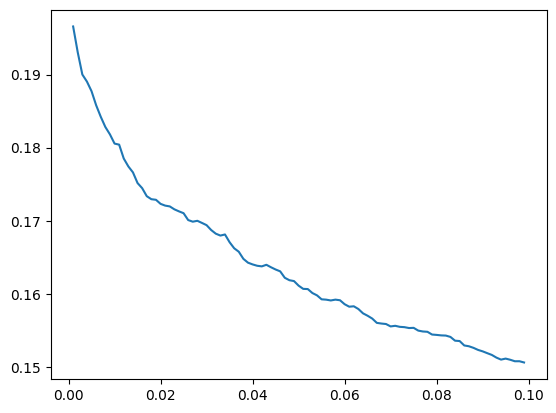

In [143]:
plt.plot(np.arange(0.001,0.1,0.001),results)

In [147]:
newPred=np.where( predictions>= 0.03, 1,0)
f1_score(val_labels,newPred,average=None)

array([0.11415168, 0.06418485, 0.08142999, 0.00694444, 0.        ,
       0.01084011, 0.01904762, 0.05875153, 0.        , 0.03442879,
       0.08183306, 0.03846154, 0.04900459, 0.0622084 , 0.        ,
       0.02903226, 0.01204819, 0.01142857, 0.05116279, 0.03333333,
       0.44510386, 0.07946027, 0.10975012, 0.03558719, 0.05272408,
       0.06342016, 0.025     , 0.03921569])

In [195]:
newPred[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0])

In [202]:
tr_labels.sum(axis=0)

tensor([ 4130.,  2328.,  2021.,   793.,   303.,   852.,   596.,  2662.,    77.,
         1451.,  2085.,   164.,  1567.,  1581.,   111.,  1110.,   153.,   545.,
         1326.,  1060., 14216.,  2469.,  2939.,  1087.,  1366.,  2189.,   641.,
         1269.])